In [40]:
import numpy as np              #Linear algebra
import pandas as pd             #Data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #
import seaborn as sns
import sklearn

In [1]:
!pip install tensorflow

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\prana\Anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 397, in _error_catcher
    yield
  File "C:\Users\prana\Anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 479, in read
    data = self._fp.read(amt)
  File "C:\Users\prana\Anaconda3\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "C:\Users\prana\Anaconda3\lib\http\client.py", line 457, in read
    n = self.readinto(b)
  File "C:\Users\prana\Anaconda3\lib\http\client.py", line 501, in readinto
    n = self.fp.readinto(b)
  File "C:\Users\prana\Anaconda3\lib\socket.py", line 589, in readinto
    return self._sock.recv_into(b)
  File "C:\Users\prana\Anaconda3\lib\ssl.py", line 1071, in recv_into
    return self.read(nbytes, buffer)
  File "C:\Users\prana\Anaconda3\lib\ssl.py", line 929, in read
    return self._sslobj.read(len, buffer)
socket.timeout: The read opera

In [41]:
insuranceDF = pd.read_csv('train.csv')
insuranceDF.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [42]:
insuranceDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
id                      381109 non-null int64
Gender                  381109 non-null object
Age                     381109 non-null int64
Driving_License         381109 non-null int64
Region_Code             381109 non-null float64
Previously_Insured      381109 non-null int64
Vehicle_Age             381109 non-null object
Vehicle_Damage          381109 non-null object
Annual_Premium          381109 non-null float64
Policy_Sales_Channel    381109 non-null float64
Vintage                 381109 non-null int64
Response                381109 non-null int64
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [43]:
insuranceDF.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [44]:
insuranceDF.corr()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,1.000000,0.001561,-0.000564,-0.000572,0.002457,0.003027,-0.002837,-0.000630,-0.001368
Age,0.001561,1.000000,-0.079782,0.042574,-0.254682,0.067507,-0.577826,-0.001264,0.111147
Driving_License,-0.000564,-0.079782,1.000000,-0.001081,0.014969,-0.011906,0.043731,-0.000848,0.010155
Region_Code,-0.000572,0.042574,-0.001081,1.000000,-0.024659,-0.010588,-0.042420,-0.002750,0.010570
Previously_Insured,0.002457,-0.254682,0.014969,-0.024659,1.000000,0.004269,0.219381,0.002537,-0.341170
Annual_Premium,0.003027,0.067507,-0.011906,-0.010588,0.004269,1.000000,-0.113247,-0.000608,0.022575
Policy_Sales_Channel,-0.002837,-0.577826,0.043731,-0.042420,0.219381,-0.113247,1.000000,0.000002,-0.139042
Vintage,-0.000630,-0.001264,-0.000848,-0.002750,0.002537,-0.000608,0.000002,1.000000,-0.001050
Response,-0.001368,0.111147,0.010155,0.010570,-0.341170,0.022575,-0.139042,-0.001050,1.000000


In [45]:
print('Percent of Missing Values :')
print("-"*25)
print(round(insuranceDF.isnull().sum()/insuranceDF.shape[0]*100,2))

Percent of Missing Values :
-------------------------
id                      0.0
Gender                  0.0
Age                     0.0
Driving_License         0.0
Region_Code             0.0
Previously_Insured      0.0
Vehicle_Age             0.0
Vehicle_Damage          0.0
Annual_Premium          0.0
Policy_Sales_Channel    0.0
Vintage                 0.0
Response                0.0
dtype: float64


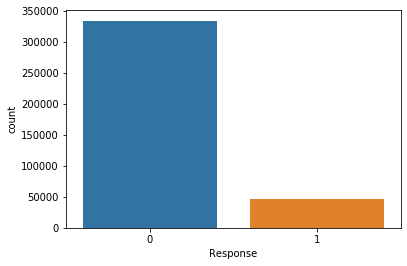

In [46]:
sns.countplot(insuranceDF.Response)

In [47]:
insuranceDF.Response.value_counts()

0    334399
1     46710
Name: Response, dtype: int64

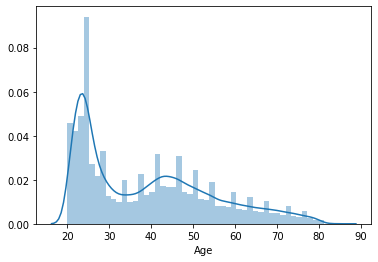

In [48]:
sns.distplot(insuranceDF.Age)

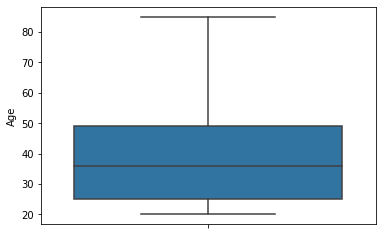

In [49]:
sns.boxplot(y = 'Age', data = insuranceDF)

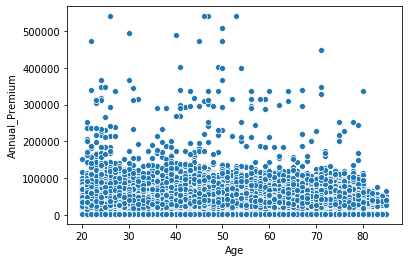

In [50]:
sns.scatterplot(x=insuranceDF['Age'], y=insuranceDF['Annual_Premium'])

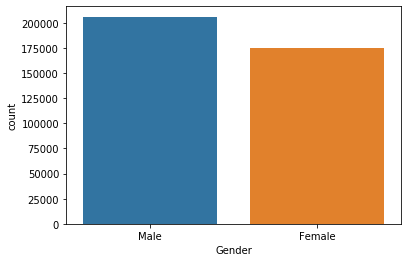

In [51]:
sns.countplot(insuranceDF.Gender)

In [52]:
df=insuranceDF.groupby(['Gender','Response'])['id'].count().to_frame().rename(columns={'id':'Count'}).reset_index()
df.head()

,Gender,Response,Count
0,Female,0,156835
1,Female,1,18185
2,Male,0,177564
3,Male,1,28525


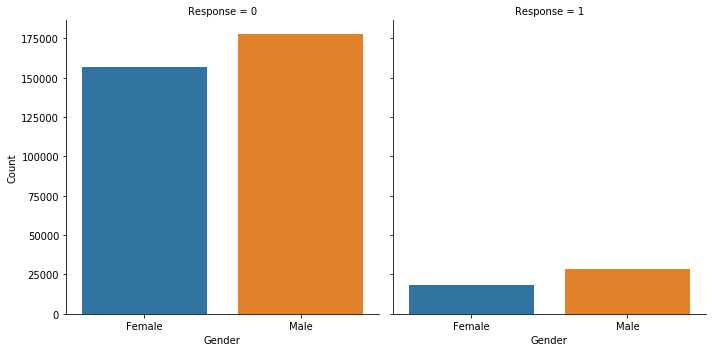

In [53]:
sns.catplot(x="Gender", y="Count", col="Response",
                data=df, kind="bar");

In [54]:
df=insuranceDF.groupby(['Gender', 'Driving_License'])['id'].count().to_frame().rename(columns={'id':'Count'}).reset_index()
df

,Gender,Driving_License,Count
0,Female,0,212
1,Female,1,174808
2,Male,0,600
3,Male,1,205489


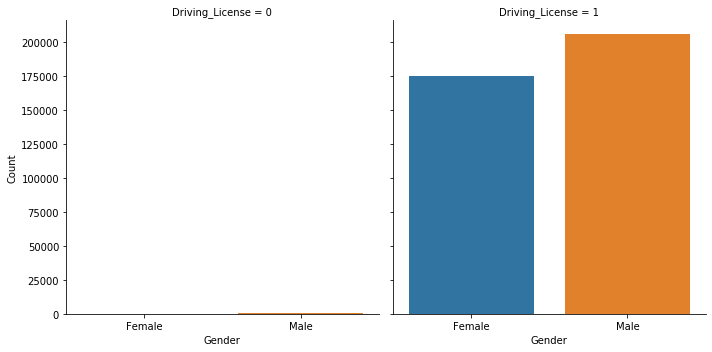

In [55]:
sns.catplot(x="Gender", y="Count", col="Driving_License",
                data=df, kind="bar");

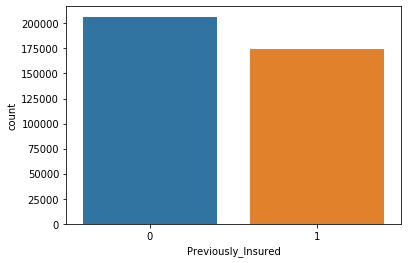

In [56]:
sns.countplot(insuranceDF['Previously_Insured'])

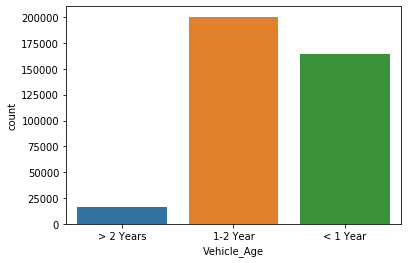

In [57]:
sns.countplot(insuranceDF.Vehicle_Age)

In [58]:
df=insuranceDF.groupby(['Vehicle_Age','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()
df

,Vehicle_Age,Response,count
0,1-2 Year,0,165510
1,1-2 Year,1,34806
2,< 1 Year,0,157584
3,< 1 Year,1,7202
4,> 2 Years,0,11305
5,> 2 Years,1,4702


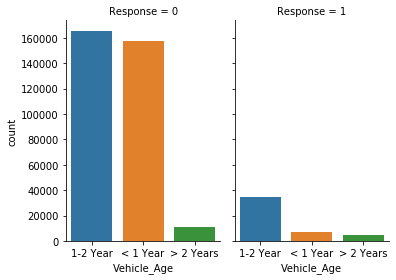

In [59]:
g = sns.catplot(x="Vehicle_Age", y="count",col="Response",
                data=df, kind="bar",
                height=4, aspect=.7)

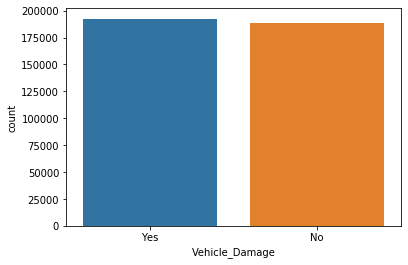

In [60]:
sns.countplot(insuranceDF.Vehicle_Damage)

In [61]:
df=insuranceDF.groupby(['Vehicle_Damage','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()
df

,Vehicle_Damage,Response,count
0,No,0,187714
1,No,1,982
2,Yes,0,146685
3,Yes,1,45728


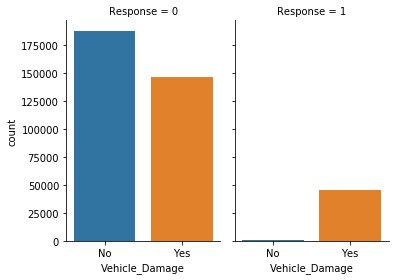

In [62]:
sns.catplot(x="Vehicle_Damage", y="count",col="Response",
                data=df, kind="bar",
                height=4, aspect=.7)

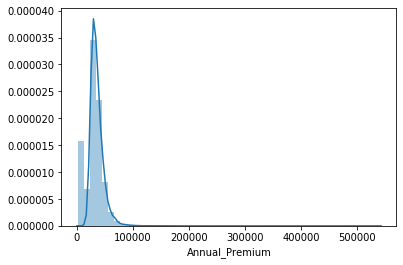

In [63]:
sns.distplot(insuranceDF.Annual_Premium)

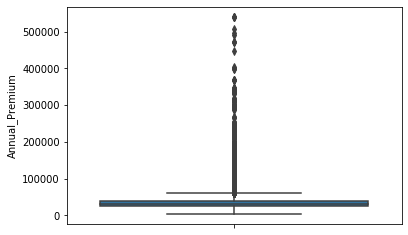

In [64]:
sns.boxplot(y = 'Annual_Premium', data = insuranceDF)

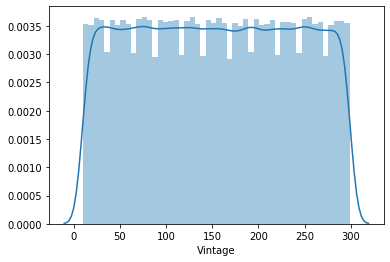

In [65]:
sns.distplot(insuranceDF.Vintage)

Data Preprocessing

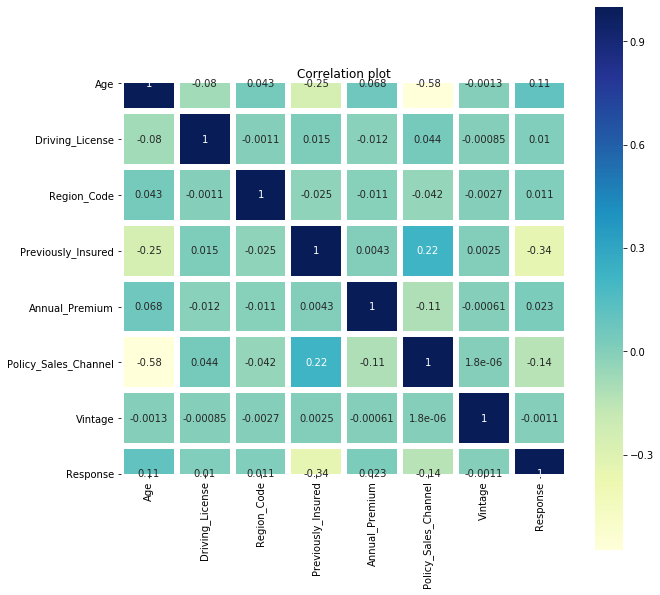

In [66]:
#insuranceDF = insuranceDF.drop(columns=['id'])
#Run only once

plt.figure(figsize=(10,10))
plt.title("Correlation plot")
sns.heatmap(insuranceDF.corr(),linewidths=5, annot=True, square=True,annot_kws={'size': 10},cmap='YlGnBu')

In [67]:
insuranceDF.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [69]:
insuranceDF.loc[insuranceDF['Gender'] == 'Male', 'Gender'] = 1
insuranceDF.loc[insuranceDF['Gender'] == 'Female', 'Gender'] = 0

insuranceDF.loc[insuranceDF['Vehicle_Age'] == '> 2 Years', 'Vehicle_Age'] = 2
insuranceDF.loc[insuranceDF['Vehicle_Age'] == '1-2 Year', 'Vehicle_Age'] = 1
insuranceDF.loc[insuranceDF['Vehicle_Age'] == '< 1 Year', 'Vehicle_Age'] = 0

insuranceDF.loc[insuranceDF['Vehicle_Damage'] == 'Yes', 'Vehicle_Damage'] = 1
insuranceDF.loc[insuranceDF['Vehicle_Damage'] == 'No', 'Vehicle_Damage'] = 0
#Run only once

insuranceDF.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,1,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,1,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,1,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,0,29,1,41.0,1,0,0,27496.0,152.0,39,0


In [71]:
for col in insuranceDF.columns:
    insuranceDF[col] = insuranceDF[col].astype(np.int32)

insuranceDF

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28,0,2,1,40454,26,217,1
1,1,76,1,3,0,1,0,33536,26,183,0
2,1,47,1,28,0,2,1,38294,26,27,1
3,1,21,1,11,1,0,0,28619,152,203,0
4,0,29,1,41,1,0,0,27496,152,39,0
...,...,...,...,...,...,...,...,...,...,...,...
381104,1,74,1,26,1,1,0,30170,26,88,0
381105,1,30,1,37,1,0,0,40016,152,131,0
381106,1,21,1,30,1,0,0,35118,160,161,0
381107,0,68,1,14,0,2,1,44617,124,74,0


In [74]:
for col in insuranceDF.columns:
    if col == 'Response':
        continue
    print(col, "\t\t", insuranceDF[col].corr(insuranceDF['Response']))

Gender 		 0.052439913771341946
Age 		 0.11114689471250962
Driving_License 		 0.010155174594073915
Region_Code 		 0.0105698556152231
Previously_Insured 		 -0.34117046261352274
Vehicle_Age 		 0.22187398721799104
Vehicle_Damage 		 0.3543995438797558
Annual_Premium 		 0.02257469554255991
Policy_Sales_Channel 		 -0.13904150082916056
Vintage 		 -0.0010503720019898848


In [76]:
X = insuranceDF.drop(['Response'], axis=1)
y = insuranceDF['Response']

In [80]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=669).fit(X)      #random_state of avg of GR numbers

In [81]:
insuranceDF['cluster'] = kmeans.labels_
insuranceDF

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,cluster
0,1,44,1,28,0,2,1,40454,26,217,1,1
1,1,76,1,3,0,1,0,33536,26,183,0,1
2,1,47,1,28,0,2,1,38294,26,27,1,1
3,1,21,1,11,1,0,0,28619,152,203,0,1
4,0,29,1,41,1,0,0,27496,152,39,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,1,74,1,26,1,1,0,30170,26,88,0,1
381105,1,30,1,37,1,0,0,40016,152,131,0,1
381106,1,21,1,30,1,0,0,35118,160,161,0,1
381107,0,68,1,14,0,2,1,44617,124,74,0,1


In [82]:
insuranceDF['cluster'].value_counts()

1    309216
0     71893
Name: cluster, dtype: int64

In [83]:
def plot_confusion_matrix(y_real, y_pred):
    cm = confusion_matrix(y_real, y_pred)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g')

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

In [84]:
'''

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
insuranceDF["Gender"] = labelencoder.fit_transform(insuranceDF["Gender"].values)
insuranceDF["Vehicle_Age"] = labelencoder.fit_transform(insuranceDF["Vehicle_Age"].values)
insuranceDF.head()

#One Hot Encoder giving errors. Try later.        <---------------------------------------------------------------

from sklearn.preprocessing import OneHotEncoder
oneHotCategoricalFeatures = ["Gender","Driving_License","Previously_Insured","Vehicle_Age","Vehicle_Damage"]
insuranceDFOneHotEncodingFeatures = insuranceDF[oneHotCategoricalFeatures].values

onehotencoder = OneHotEncoder(sparse=False)
insuranceDFOneHotEncodedFeatures = onehotencoder.fit_transform(oneHotCategoricalFeatures)

insuranceDF.head()


insuranceDF



insuranceDF.head()



from sklearn.model_selection import train_test_split

x = insuranceDF.drop(labels= ['Response'], axis=1)
y = insuranceDF.Response

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, random_state = 0)

print(xtrain.shape, '\n', xtest.shape)

from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(xtrain, ytrain)

ypred_LR = LR.predict(xtest)
ypredList = list(ypred_LR)
ytestList = list(ytest)

from sklearn.metrics import confusion_matrix
CM = confusion_matrix(ytest,ypred_LR)
CM

from sklearn.metrics import accuracy_score
acc = accuracy_score(ytest,ypred_LR)
acc

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

probs = LR.predict_proba(xtest)
probs = probs[:, 1]
probs

auc = roc_auc_score(ytest,ypred_LR)
print('AUC: %.3f' % auc)

%matplotlib notebook
# calculate roc curve
fpr, tpr, thresholds = roc_curve(ytest, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

'''

'\n\nfrom sklearn.preprocessing import LabelEncoder\nlabelencoder = LabelEncoder()\ninsuranceDF["Gender"] = labelencoder.fit_transform(insuranceDF["Gender"].values)\ninsuranceDF["Vehicle_Age"] = labelencoder.fit_transform(insuranceDF["Vehicle_Age"].values)\ninsuranceDF.head()\n\n#One Hot Encoder giving errors. Try later.        <---------------------------------------------------------------\n\nfrom sklearn.preprocessing import OneHotEncoder\noneHotCategoricalFeatures = ["Gender","Driving_License","Previously_Insured","Vehicle_Age","Vehicle_Damage"]\ninsuranceDFOneHotEncodingFeatures = insuranceDF[oneHotCategoricalFeatures].values\n\nonehotencoder = OneHotEncoder(sparse=False)\ninsuranceDFOneHotEncodedFeatures = onehotencoder.fit_transform(oneHotCategoricalFeatures)\n\ninsuranceDF.head()\n\n\ninsuranceDF\n\n\n\ninsuranceDF.head()\n\n\n\nfrom sklearn.model_selection import train_test_split\n\nx = insuranceDF.drop(labels= [\'Response\'], axis=1)\ny = insuranceDF.Response\n\nxtrain, xtest